## Imports and Data

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.utils import prettyTable, project_root

PROJECT_ROOT = Path.cwd().parents[0]  # notebook is in notebooks/
DATA_DIR = PROJECT_ROOT / "data"

pd.set_option("display.max_columns", 20)
sns.set_theme(style="darkgrid", palette="bright", context="notebook")


In [3]:
ig_oas = pd.read_csv(DATA_DIR / "ig_oas.csv", parse_dates=["date"], index_col="date")
dgs10 = pd.read_csv(DATA_DIR / "dgs10.csv", parse_dates=["date"], index_col="date")
t10y2y = pd.read_csv(DATA_DIR / "t10y2y.csv", parse_dates=["date"], index_col="date")

df = (
    ig_oas.rename(columns={"value": "ig_oas"})
    .join(dgs10.rename(columns={"value": "dgs10"}), how="inner")
    .join(t10y2y.rename(columns={"value": "t10y2y"}), how="inner")
    .sort_index()
)

df.head()

,ig_oas,dgs10,t10y2y
date,,,
1996-12-31,0.60,6.43,0.55
1997-01-01,NaN,NaN,NaN
1997-01-02,0.60,6.54,0.57
1997-01-03,0.61,6.52,0.57
1997-01-06,0.61,6.54,0.57


In [4]:
df.info()

df.describe(percentiles=[0.1, 0.5, 0.9]).T

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7549 entries, 1996-12-31 to 2025-12-05
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ig_oas  7456 non-null   float64
 1   dgs10   7237 non-null   float64
 2   t10y2y  7237 non-null   float64
dtypes: float64(3)
memory usage: 235.9 KB


,count,mean,std,min,10%,50%,90%,max
ig_oas,7456.0,1.473006,0.821139,0.53,0.87,1.28,2.180,6.56
dgs10,7237.0,3.572841,1.448409,0.52,1.72,3.70,5.544,6.98
t10y2y,7237.0,0.976999,0.955812,-1.08,-0.14,0.83,2.360,2.91


## Plots and Statistics

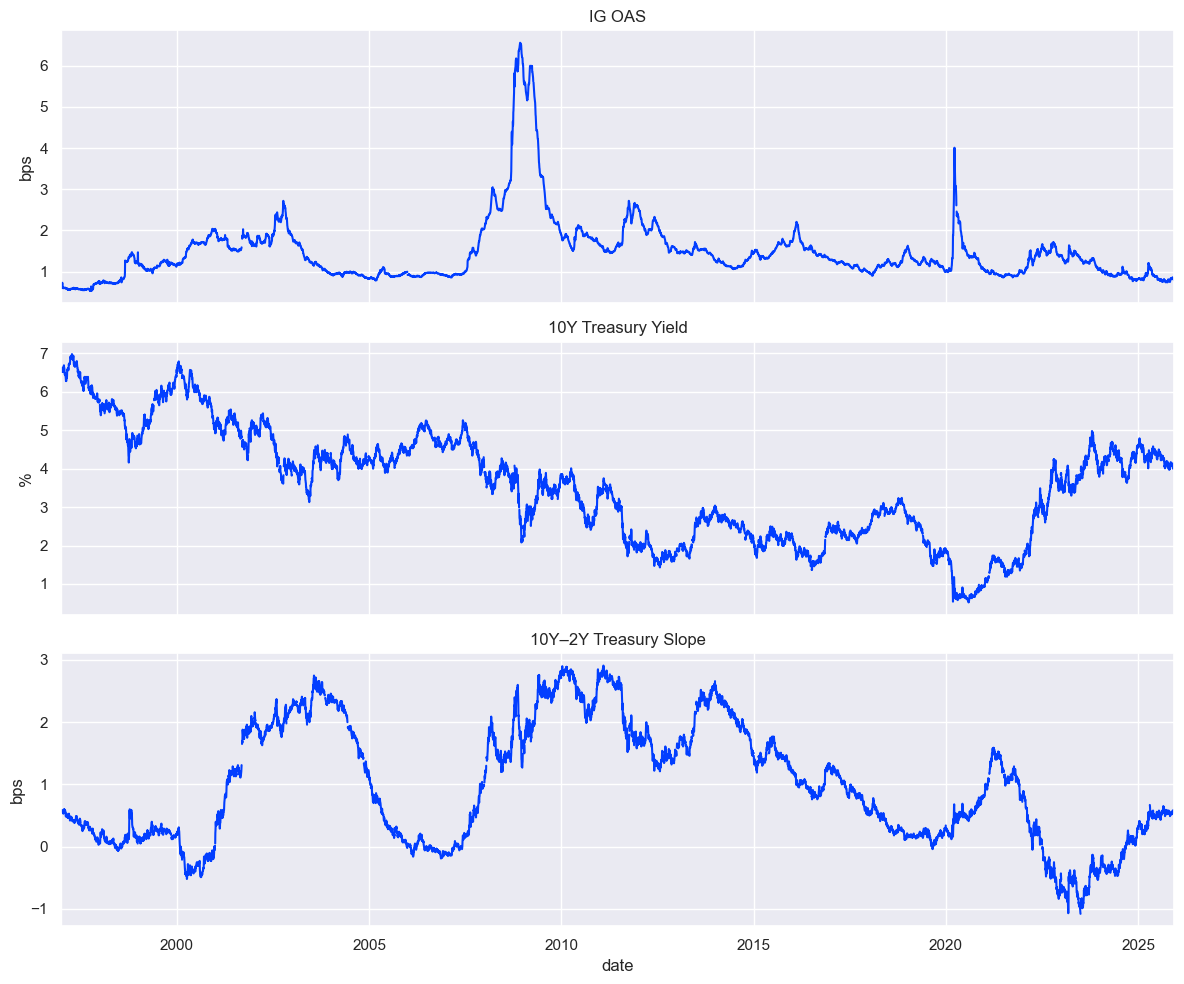

In [5]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

df["ig_oas"].plot(ax=axes[0])
axes[0].set_title("IG OAS")
axes[0].set_ylabel("bps")

df["dgs10"].plot(ax=axes[1])
axes[1].set_title("10Y Treasury Yield")
axes[1].set_ylabel("%")

df["t10y2y"].plot(ax=axes[2])
axes[2].set_title("10Y–2Y Treasury Slope")
axes[2].set_ylabel("bps")

plt.tight_layout()
plt.show()


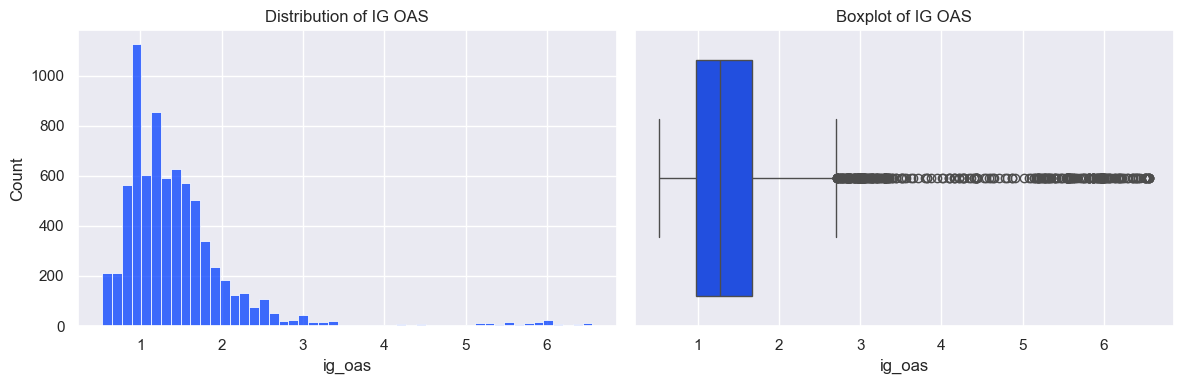

count    7456.000000
mean        1.473006
std         0.821139
min         0.530000
50%         1.280000
80%         1.770000
90%         2.180000
95%         2.602500
max         6.560000
Name: ig_oas, dtype: float64

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(df["ig_oas"].dropna(), bins=50, ax=ax[0])
ax[0].set_title("Distribution of IG OAS")

sns.boxplot(x=df["ig_oas"], ax=ax[1])
ax[1].set_title("Boxplot of IG OAS")

plt.tight_layout()
plt.show()

df["ig_oas"].describe(percentiles=[0.8, 0.9, 0.95])

## Initial Modeling

In [7]:
stress_threshold = df["ig_oas"].quantile(0.90)
stress_threshold

np.float64(2.18)

In [8]:
df["regime_stress"] = (df["ig_oas"] >= stress_threshold).astype(int)
df["regime_stress"].value_counts(normalize=True)

regime_stress
0    0.900252
1    0.099748
Name: proportion, dtype: float64

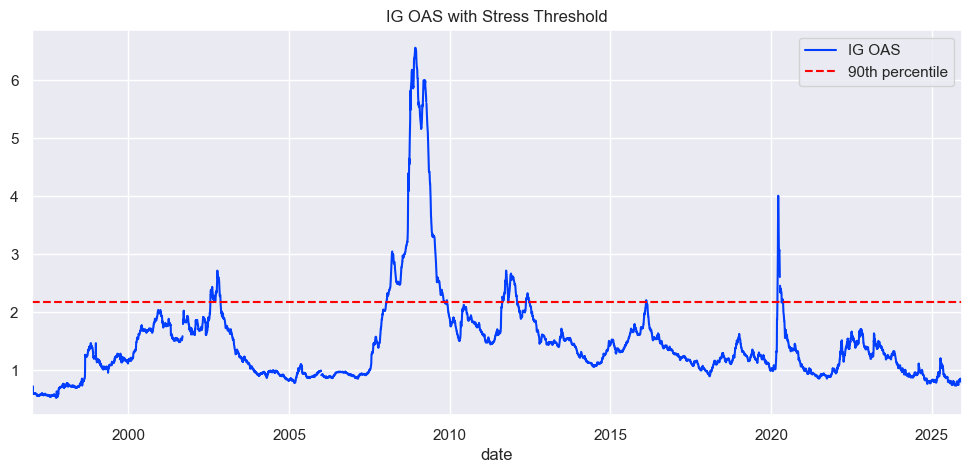

In [9]:
fig, ax = plt.subplots(figsize=(12, 5))
df["ig_oas"].plot(ax=ax, label="IG OAS")
ax.axhline(stress_threshold, color="red", linestyle="--", label="90th percentile")
ax.set_title("IG OAS with Stress Threshold")
ax.legend()
plt.show()

In [10]:
df["ig_oas_chg"] = df["ig_oas"].diff()
df["dgs10_chg"] = df["dgs10"].diff()
df["t10y2y_chg"] = df["t10y2y"].diff()

# Rolling 20-day volatility of OAS
window = 20
df["ig_oas_roll_vol"] = df["ig_oas_chg"].rolling(window).std()

# Simple lags
df["ig_oas_lag1"] = df["ig_oas"].shift(1)
df["dgs10_lag1"] = df["dgs10"].shift(1)
df["t10y2y_lag1"] = df["t10y2y"].shift(1)

df_features = df.dropna().copy()
df_features.head()

,ig_oas,dgs10,t10y2y,regime_stress,ig_oas_chg,dgs10_chg,t10y2y_chg,ig_oas_roll_vol,ig_oas_lag1,dgs10_lag1,t10y2y_lag1
date,,,,,,,,,,,
1997-01-30,0.60,6.61,0.60,0,0.00,-0.02,0.01,0.037975,0.60,6.63,0.59
1997-01-31,0.61,6.53,0.59,0,0.01,-0.08,-0.01,0.037975,0.60,6.61,0.60
1997-02-03,0.61,6.47,0.58,0,0.00,-0.06,-0.01,0.037975,0.61,6.53,0.59
1997-02-04,0.61,6.45,0.57,0,0.00,-0.02,-0.01,0.037975,0.61,6.47,0.58
1997-02-05,0.60,6.47,0.56,0,-0.01,0.02,-0.01,0.037975,0.61,6.45,0.57


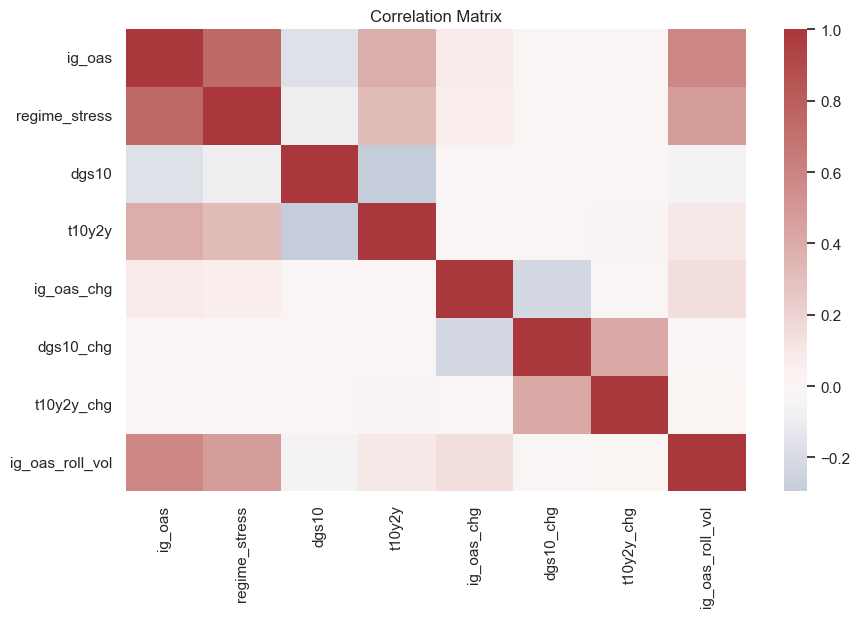

In [11]:
corr_cols = [
    "ig_oas",
    "regime_stress",
    "dgs10",
    "t10y2y",
    "ig_oas_chg",
    "dgs10_chg",
    "t10y2y_chg",
    "ig_oas_roll_vol",
]

plt.figure(figsize=(10, 6))
sns.heatmap(df_features[corr_cols].corr(), annot=False, cmap="vlag", center=0)
plt.title("Correlation Matrix")
plt.show()

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

feature_cols = [
    "ig_oas_lag1",      # yesterday's spread
    "dgs10_lag1",       # yesterday's 10Y rate
    "t10y2y_lag1",      # yesterday's slope
    "ig_oas_roll_vol",  # recent volatility
]

X = df_features[feature_cols]
y = df_features["regime_stress"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=False  # time series → no random shuffle
)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1671
           1       1.00      0.88      0.94        26

    accuracy                           1.00      1697
   macro avg       1.00      0.94      0.97      1697
weighted avg       1.00      1.00      1.00      1697

ROC AUC: 0.9998849146066381


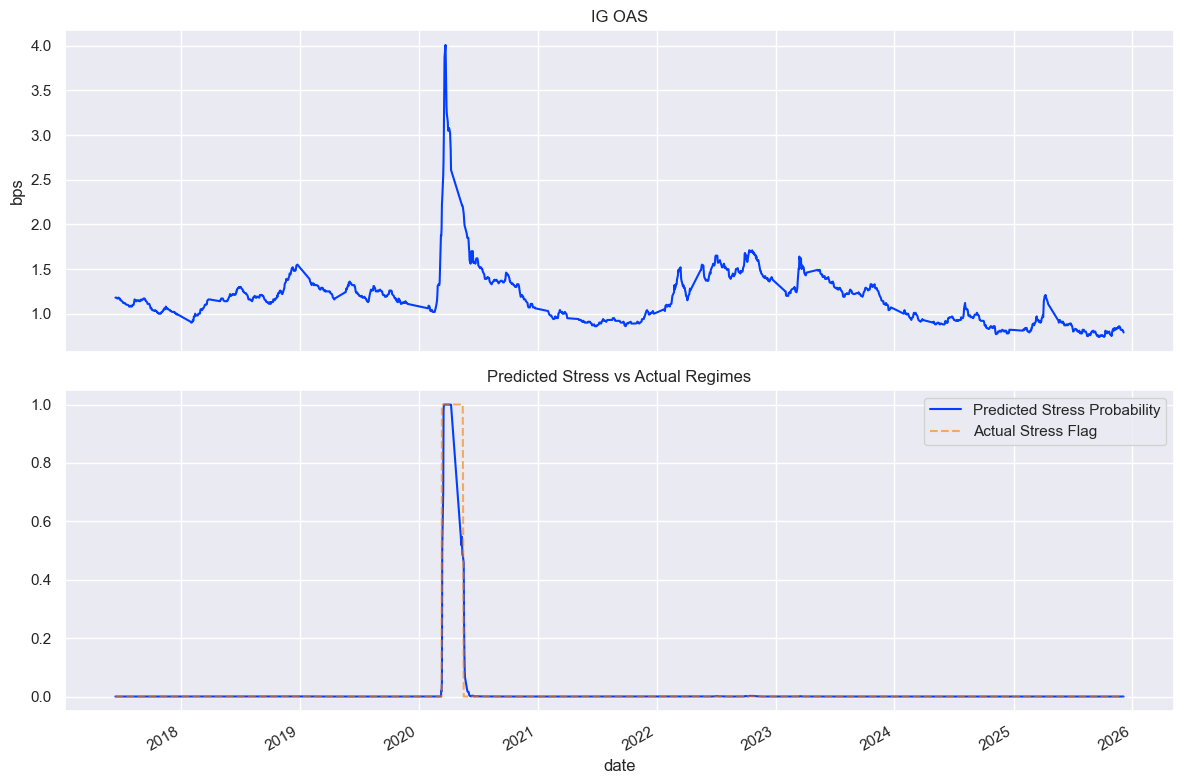

In [13]:
df_pred = df_features.loc[X_test.index].copy()
df_pred["stress_prob"] = y_proba
df_pred["regime_stress_pred"] = y_pred

fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

df_pred["ig_oas"].plot(ax=ax[0])
ax[0].set_title("IG OAS")
ax[0].set_ylabel("bps")

df_pred["stress_prob"].plot(ax=ax[1], label="Predicted Stress Probability")
df_pred["regime_stress"].plot(
    ax=ax[1], secondary_y=False, linestyle="--", alpha=0.6, label="Actual Stress Flag"
)
ax[1].set_title("Predicted Stress vs Actual Regimes")
ax[1].legend()

plt.tight_layout()
plt.show()


## Adjusting Features

In [14]:
df = df.copy()
df = df.dropna(subset=["ig_oas", "dgs10", "t10y2y"]).sort_index()

# Ensure correct units interpretation:
# ig_oas is typically in percent (e.g., 1.2 meaning 120 bps) on FRED for some series;
# dgs10 is percent; t10y2y is percent/points depending on series.
# We won't change units yet—just be consistent.
df.tail()

,ig_oas,dgs10,t10y2y,regime_stress,ig_oas_chg,dgs10_chg,t10y2y_chg,ig_oas_roll_vol,ig_oas_lag1,dgs10_lag1,t10y2y_lag1
date,,,,,,,,,,,
2025-12-01,0.82,4.09,0.55,0,0.00,0.07,0.00,0.011910,0.82,4.02,0.55
2025-12-02,0.81,4.09,0.58,0,-0.01,0.00,0.03,0.012096,0.82,4.09,0.55
2025-12-03,0.81,4.06,0.57,0,0.00,-0.03,-0.01,0.011239,0.81,4.09,0.58
2025-12-04,0.80,4.11,0.59,0,-0.01,0.05,0.02,0.011192,0.81,4.06,0.57
2025-12-05,0.79,4.14,0.58,0,-0.01,0.03,-0.01,0.010195,0.80,4.11,0.59


In [15]:
stress_q = 0.90
stress_threshold = df["ig_oas"].quantile(stress_q)
df["stress"] = (df["ig_oas"] >= stress_threshold).astype(int)

df["stress"].value_counts(normalize=True), stress_threshold

(stress
 0    0.899128
 1    0.100872
 Name: proportion, dtype: float64,
 np.float64(2.18))

In [16]:
# creating lagged values
import numpy as np

def lag(s, k=1):
    return s.shift(k)

# Changes (macro)
df["dgs10_chg1"] = df["dgs10"].diff()
df["t10y2y_chg1"] = df["t10y2y"].diff()

# Rolling vol (lagged to avoid using today's value)
w = 20
df["dgs10_vol20"] = lag(df["dgs10_chg1"], 1).rolling(w).std()
df["t10y2y_vol20"] = lag(df["t10y2y_chg1"], 1).rolling(w).std()

# Lags of levels (macro levels are allowed)
df["dgs10_lag1"] = lag(df["dgs10"], 1)
df["t10y2y_lag1"] = lag(df["t10y2y"], 1)

# Lags of changes
df["dgs10_chg1_lag1"] = lag(df["dgs10_chg1"], 1)
df["t10y2y_chg1_lag1"] = lag(df["t10y2y_chg1"], 1)

# Optional: interaction (macro regime proxy)
df["rate_level_x_slope"] = df["dgs10_lag1"] * df["t10y2y_lag1"]

model_df = df.dropna().copy()
model_df.head()

,ig_oas,dgs10,t10y2y,regime_stress,ig_oas_chg,dgs10_chg,t10y2y_chg,ig_oas_roll_vol,ig_oas_lag1,dgs10_lag1,t10y2y_lag1,stress,dgs10_chg1,t10y2y_chg1,dgs10_vol20,t10y2y_vol20,dgs10_chg1_lag1,t10y2y_chg1_lag1,rate_level_x_slope
date,,,,,,,,,,,,,,,,,,,
1997-01-31,0.61,6.53,0.59,0,0.01,-0.08,-0.01,0.037975,0.60,6.61,0.60,0,-0.08,-0.01,0.053891,0.016819,-0.02,0.01,3.9660
1997-02-03,0.61,6.47,0.58,0,0.00,-0.06,-0.01,0.037975,0.61,6.53,0.59,0,-0.06,-0.01,0.051858,0.016512,-0.08,-0.01,3.8527
1997-02-04,0.61,6.45,0.57,0,0.00,-0.02,-0.01,0.037975,0.61,6.47,0.58,0,-0.02,-0.01,0.053398,0.016694,-0.06,-0.01,3.7526
1997-02-05,0.60,6.47,0.56,0,-0.01,0.02,-0.01,0.037975,0.61,6.45,0.57,0,0.02,-0.01,0.053260,0.016859,-0.02,-0.01,3.6765
1997-02-06,0.60,6.49,0.58,0,0.00,0.02,0.02,0.037683,0.60,6.47,0.56,0,0.02,0.02,0.052965,0.016311,0.02,-0.01,3.6232


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

feature_cols = [
    "dgs10_lag1",
    "t10y2y_lag1",
    "dgs10_chg1_lag1",
    "t10y2y_chg1_lag1",
    "dgs10_vol20",
    "t10y2y_vol20",
    "rate_level_x_slope",
]

X = model_df[feature_cols]
y = model_df["stress"]

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

# Walk-forward by calendar year
years = sorted(model_df.index.year.unique())

results = []
min_train_years = 5  # require at least 5 years before testing
for i in range(min_train_years, len(years)):
    train_years = years[:i]
    test_year = years[i]

    train_idx = model_df.index.year.isin(train_years)
    test_idx = model_df.index.year == test_year

    X_train, y_train = X.loc[train_idx], y.loc[train_idx]
    X_test, y_test = X.loc[test_idx], y.loc[test_idx]

    # Skip years with no class diversity
    if y_test.nunique() < 2 or y_train.nunique() < 2:
        continue

    pipe.fit(X_train, y_train)
    y_proba = pipe.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)

    results.append((test_year, auc, int(test_idx.sum())))

results[:5], len(results)

([(2009, 0.9522586169985013, 200),
  (2011, 0.9622282608695651, 218),
  (2012, 0.7339393939393939, 183),
  (2016, 0.6035353535353536, 200),
  (2020, 0.9606593406593406, 201)],
 5)

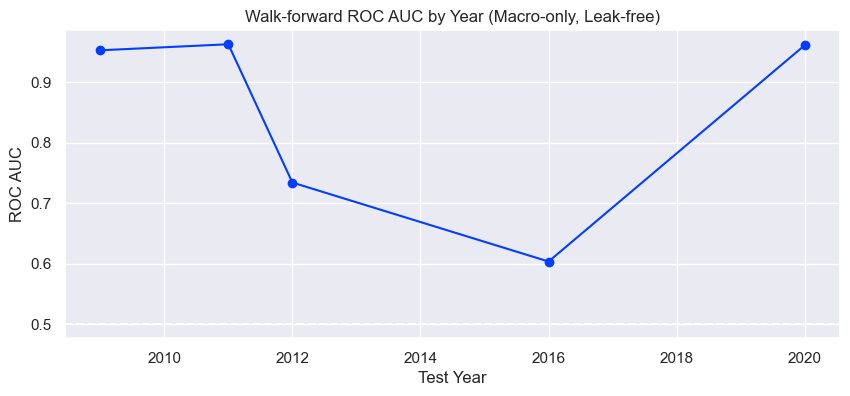

,year,auc,n_obs
count,5.000000,5.000000,5.000000
mean,2013.600000,0.842524,200.400000
std,4.393177,0.165252,12.381438
min,2009.000000,0.603535,183.000000
25%,2011.000000,0.733939,200.000000
50%,2012.000000,0.952259,200.000000
75%,2016.000000,0.960659,201.000000
max,2020.000000,0.962228,218.000000


In [18]:
import pandas as pd
import matplotlib.pyplot as plt

res_df = pd.DataFrame(results, columns=["year", "auc", "n_obs"])

plt.figure(figsize=(10, 4))
plt.plot(res_df["year"], res_df["auc"], marker="o")
plt.axhline(0.5, linestyle="--")
plt.title("Walk-forward ROC AUC by Year (Macro-only, Leak-free)")
plt.ylabel("ROC AUC")
plt.xlabel("Test Year")
plt.show()

res_df.describe()

In [19]:
res_df

,year,auc,n_obs
0,2009,0.952259,200
1,2011,0.962228,218
2,2012,0.733939,183
3,2016,0.603535,200
4,2020,0.960659,201


In [20]:
# This should NOT exist in feature set anymore:
set(feature_cols) & {"ig_oas", "ig_oas_lag1", "ig_oas_roll_vol"}

set()

In [21]:
# Observation-weighted mean ROC AUC across walk-forward years.

import numpy as np

weighted_auc = np.average(
    res_df["auc"],
    weights=res_df["n_obs"]
)

weighted_auc

np.float64(0.8466347220955814)

In [22]:
# If I pool all out-of-sample predictions across time, how well do they rank stress vs normal?
from sklearn.metrics import roc_auc_score

all_y = []
all_proba = []

for i in range(min_train_years, len(years)):
    train_years = years[:i]
    test_year = years[i]

    train_idx = model_df.index.year.isin(train_years)
    test_idx = model_df.index.year == test_year

    X_train, y_train = X.loc[train_idx], y.loc[train_idx]
    X_test, y_test = X.loc[test_idx], y.loc[test_idx]

    if y_test.nunique() < 2 or y_train.nunique() < 2:
        continue

    pipe.fit(X_train, y_train)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    all_y.append(y_test)
    all_proba.append(pd.Series(y_proba, index=y_test.index))

In [23]:
y_all = pd.concat(all_y)
proba_all = pd.concat(all_proba)

pooled_auc = roc_auc_score(y_all, proba_all)
pooled_auc

0.939448785365131

In [24]:
res_df["auc"].describe()

count    5.000000
mean     0.842524
std      0.165252
min      0.603535
25%      0.733939
50%      0.952259
75%      0.960659
max      0.962228
Name: auc, dtype: float64

## Predicting Stress Entry Points

In [25]:
df = df.copy().dropna(subset=["ig_oas", "dgs10", "t10y2y"]).sort_index()

stress_q = 0.90
stress_threshold = df["ig_oas"].quantile(stress_q)

df["stress"] = (df["ig_oas"] >= stress_threshold).astype(int)
stress_threshold, df["stress"].value_counts(normalize=True)

(np.float64(2.18),
 stress
 0    0.899128
 1    0.100872
 Name: proportion, dtype: float64)

In [26]:
H = 21  # horizon (trading days)

# Will stress occur at any point in the next H days?
# Equivalent to a forward-looking "max" of stress over the next H days.
df["stress_in_next_H"] = (
    df["stress"]
      .shift(-1)                     # start "tomorrow" so it's truly forward
      .rolling(H, min_periods=H)
      .max()
)

# Entry label: tomorrow->H contains stress AND today is not stress
df["stress_entry_H"] = ((df["stress"] == 0) & (df["stress_in_next_H"] == 1)).astype(int)

df[["stress", "stress_in_next_H", "stress_entry_H"]].tail(30)

,stress,stress_in_next_H,stress_entry_H
date,,,
2025-10-23,0,0.0,0
2025-10-24,0,0.0,0
2025-10-27,0,0.0,0
2025-10-28,0,0.0,0
2025-10-29,0,0.0,0
2025-10-30,0,0.0,0
2025-10-31,0,0.0,0
2025-11-03,0,0.0,0
2025-11-04,0,0.0,0


In [27]:
df["stress_entry_H"].value_counts(normalize=True), df["stress_entry_H"].sum()


(stress_entry_H
 0    0.98132
 1    0.01868
 Name: proportion, dtype: float64,
 np.int64(135))

In [28]:
model_df = df.copy()

# Macro changes
model_df["dgs10_chg1"] = model_df["dgs10"].diff()
model_df["t10y2y_chg1"] = model_df["t10y2y"].diff()

# Lags of macro levels
model_df["dgs10_lag1"] = model_df["dgs10"].shift(1)
model_df["t10y2y_lag1"] = model_df["t10y2y"].shift(1)

# Lags of changes
model_df["dgs10_chg1_lag1"] = model_df["dgs10_chg1"].shift(1)
model_df["t10y2y_chg1_lag1"] = model_df["t10y2y_chg1"].shift(1)

# Rolling vol (computed on lagged changes)
w = 20
model_df["dgs10_vol20"] = model_df["dgs10_chg1"].shift(1).rolling(w).std()
model_df["t10y2y_vol20"] = model_df["t10y2y_chg1"].shift(1).rolling(w).std()

# Interaction
model_df["rate_level_x_slope"] = model_df["dgs10_lag1"] * model_df["t10y2y_lag1"]

feature_cols = [
    "dgs10_lag1",
    "t10y2y_lag1",
    "dgs10_chg1_lag1",
    "t10y2y_chg1_lag1",
    "dgs10_vol20",
    "t10y2y_vol20",
    "rate_level_x_slope",
]

entry_df = model_df.dropna(subset=feature_cols + ["stress_entry_H"]).copy()

X = entry_df[feature_cols]
y = entry_df["stress_entry_H"]

y.value_counts(normalize=True), y.sum()

(stress_entry_H
 0    0.981266
 1    0.018734
 Name: proportion, dtype: float64,
 np.int64(135))

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=3000, class_weight="balanced"))
])

years = sorted(entry_df.index.year.unique())

results = []
all_y = []
all_proba = []

min_train_years = 5

for i in range(min_train_years, len(years)):
    train_years = years[:i]
    test_year = years[i]

    train_idx = entry_df.index.year.isin(train_years)
    test_idx = entry_df.index.year == test_year

    X_train, y_train = X.loc[train_idx], y.loc[train_idx]
    X_test, y_test = X.loc[test_idx], y.loc[test_idx]

    # Need both classes in train and test for AUC
    if y_train.nunique() < 2 or y_test.nunique() < 2:
        continue

    pipe.fit(X_train, y_train)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_proba)
    results.append((test_year, auc, int(test_idx.sum()), int(y_test.sum())))

    all_y.append(y_test)
    all_proba.append(pd.Series(y_proba, index=y_test.index))

res_df = pd.DataFrame(results, columns=["year", "auc", "n_obs", "n_entries"])
res_df

,year,auc,n_obs,n_entries
0,2008,0.456000,251,1
1,2009,0.155398,250,31
2,2011,0.316532,250,2
3,2012,0.430144,249,40
4,2016,0.400652,250,20
5,2020,0.671222,251,21


In [30]:
weighted_auc = np.average(res_df["auc"], weights=res_df["n_obs"])
y_all = pd.concat(all_y)
proba_all = pd.concat(all_proba)
pooled_auc = roc_auc_score(y_all, proba_all)

weighted_auc, pooled_auc, res_df["auc"].describe()

(np.float64(0.4051859186134172),
 0.3808519982433026,
 count    6.000000
 mean     0.404991
 std      0.169855
 min      0.155398
 25%      0.337562
 50%      0.415398
 75%      0.449536
 max      0.671222
 Name: auc, dtype: float64)

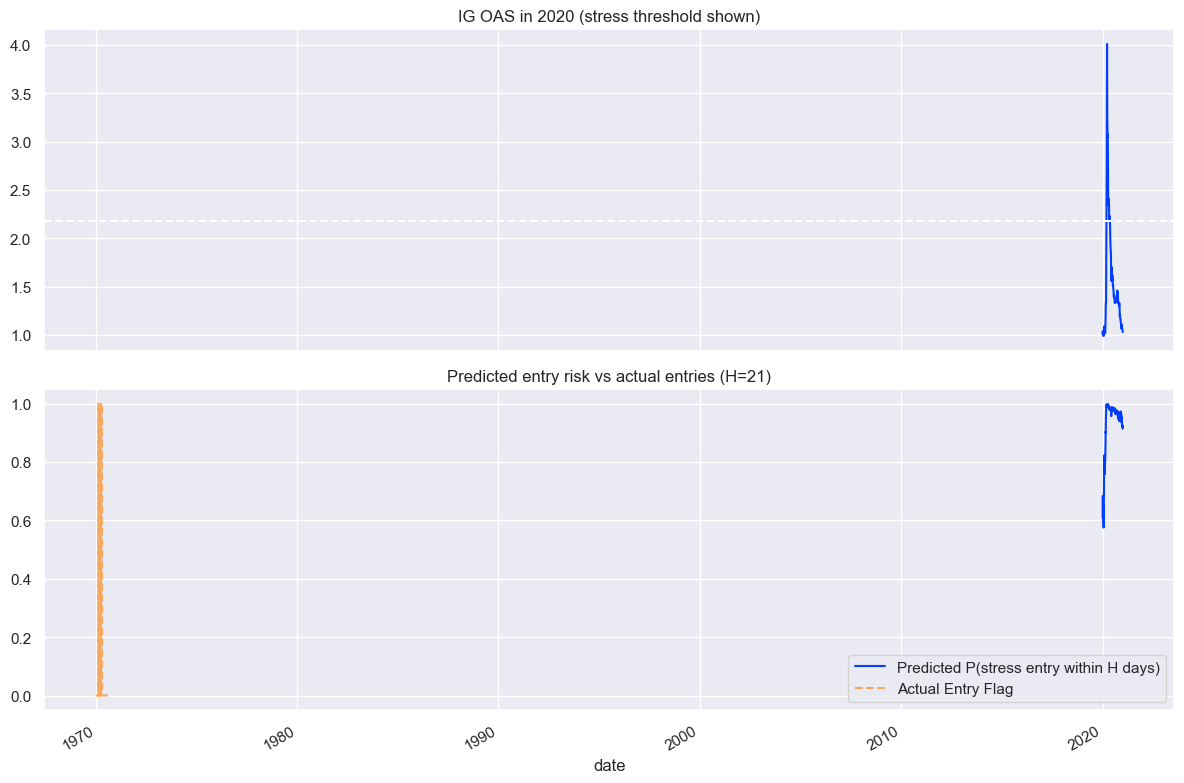

In [31]:
import matplotlib.pyplot as plt

# pick a year you have in res_df:
yr = res_df["year"].iloc[-1]
mask = entry_df.index.year == yr

# refit on all prior years
train_mask = entry_df.index.year < yr
pipe.fit(X.loc[train_mask], y.loc[train_mask])
proba = pipe.predict_proba(X.loc[mask])[:, 1]

plot_df = entry_df.loc[mask].copy()
plot_df["entry_prob"] = proba

fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

plot_df["ig_oas"].plot(ax=ax[0])
ax[0].axhline(stress_threshold, linestyle="--")
ax[0].set_title(f"IG OAS in {yr} (stress threshold shown)")

plot_df["entry_prob"].plot(ax=ax[1], label="Predicted P(stress entry within H days)")
ax[1].plot(plot_df["stress_entry_H"].values, linestyle="--", alpha=0.6, label="Actual Entry Flag")
ax[1].set_title(f"Predicted entry risk vs actual entries (H={H})")
ax[1].legend()

plt.tight_layout()
plt.show()

In [32]:
print(res_df)
print(weighted_auc, pooled_auc)
print(y.sum())

   year       auc  n_obs  n_entries
0  2008  0.456000    251          1
1  2009  0.155398    250         31
2  2011  0.316532    250          2
3  2012  0.430144    249         40
4  2016  0.400652    250         20
5  2020  0.671222    251         21
0.4051859186134172 0.3808519982433026
135


In [33]:
res_df

,year,auc,n_obs,n_entries
0,2008,0.456000,251,1
1,2009,0.155398,250,31
2,2011,0.316532,250,2
3,2012,0.430144,249,40
4,2016,0.400652,250,20
5,2020,0.671222,251,21


## Minimum-duration stress entry labels

In [34]:
from src.features import compute_stress_flag, stress_episode_entry, entry_within_horizon

df = df.copy().dropna(subset=["ig_oas", "dgs10", "t10y2y"]).sort_index()

stress_q = 0.90
D = 10   # minimum duration (days)
H = 21   # prediction horizon (days)

df["stress"], stress_threshold = compute_stress_flag(df, oas_col="ig_oas", stress_q=stress_q)
df["stress_entry"] = stress_episode_entry(df["stress"], min_duration=D)
df["stress_entry_H"] = entry_within_horizon(df["stress_entry"], df["stress"], horizon=H)

stress_threshold, df[["stress", "stress_entry", "stress_entry_H"]].sum()

/Users/chadwickballoo/Coding/projects/credit_spread_regime/src/features.py:42: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  entry = (qualifying & (~qualifying.shift(1).fillna(False))).astype(int)


(2.18,
 stress            729
 stress_entry        7
 stress_entry_H     16
 dtype: int64)

In [35]:
df[["ig_oas", "stress", "stress_entry", "stress_entry_H"]].tail(60)

,ig_oas,stress,stress_entry,stress_entry_H
date,,,,
2025-09-10,0.79,0,0,0
2025-09-11,0.78,0,0,0
2025-09-12,0.77,0,0,0
2025-09-15,0.75,0,0,0
2025-09-16,0.76,0,0,0
2025-09-17,0.76,0,0,0
2025-09-18,0.75,0,0,0
2025-09-19,0.74,0,0,0
2025-09-22,0.74,0,0,0


In [36]:
import numpy as np

model_df = df.copy()

# Macro changes
model_df["dgs10_chg1"] = model_df["dgs10"].diff()
model_df["t10y2y_chg1"] = model_df["t10y2y"].diff()

# Lags of levels
model_df["dgs10_lag1"] = model_df["dgs10"].shift(1)
model_df["t10y2y_lag1"] = model_df["t10y2y"].shift(1)

# Lags of changes
model_df["dgs10_chg1_lag1"] = model_df["dgs10_chg1"].shift(1)
model_df["t10y2y_chg1_lag1"] = model_df["t10y2y_chg1"].shift(1)

# Rolling vol on lagged changes (no look-ahead)
w = 20
model_df["dgs10_vol20"] = model_df["dgs10_chg1"].shift(1).rolling(w).std()
model_df["t10y2y_vol20"] = model_df["t10y2y_chg1"].shift(1).rolling(w).std()

# Interaction
model_df["rate_level_x_slope"] = model_df["dgs10_lag1"] * model_df["t10y2y_lag1"]

feature_cols = [
    "dgs10_lag1",
    "t10y2y_lag1",
    "dgs10_chg1_lag1",
    "t10y2y_chg1_lag1",
    "dgs10_vol20",
    "t10y2y_vol20",
    "rate_level_x_slope",
]

eval_df = model_df.dropna(subset=feature_cols + ["stress_entry_H"]).copy()

X = eval_df[feature_cols]
y = eval_df["stress_entry_H"]

y.value_counts(), y.mean()

(stress_entry_H
 0    7190
 1      16
 Name: count, dtype: int64,
 np.float64(0.0022203719122953097))

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=3000, class_weight="balanced"))
])

years = sorted(eval_df.index.year.unique())
min_train_years = 5

results = []
all_y = []
all_proba = []

for i in range(min_train_years, len(years)):
    train_years = years[:i]
    test_year = years[i]

    train_idx = eval_df.index.year.isin(train_years)
    test_idx = eval_df.index.year == test_year

    X_train, y_train = X.loc[train_idx], y.loc[train_idx]
    X_test, y_test = X.loc[test_idx], y.loc[test_idx]

    if y_train.nunique() < 2 or y_test.nunique() < 2:
        continue

    pipe.fit(X_train, y_train)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_proba)
    results.append((test_year, auc, int(test_idx.sum()), int(y_test.sum())))

    all_y.append(y_test)
    all_proba.append(pd.Series(y_proba, index=y_test.index))

res_df = pd.DataFrame(results, columns=["year", "auc", "n_obs", "n_pos"])
res_df

,year,auc,n_obs,n_pos
0,2008,0.968000,251,1
1,2011,0.094758,250,2
2,2012,0.213710,249,1
3,2020,0.554167,251,11


In [38]:
import numpy as np

weighted_auc = np.average(res_df["auc"], weights=res_df["n_obs"])
y_all = pd.concat(all_y)
proba_all = pd.concat(all_proba)
pooled_auc = roc_auc_score(y_all, proba_all)

weighted_auc, pooled_auc, res_df["auc"].describe()

(np.float64(0.45850855058919565),
 0.5788370520622041,
 count    4.000000
 mean     0.457659
 std      0.391991
 min      0.094758
 25%      0.183972
 50%      0.383938
 75%      0.657625
 max      0.968000
 Name: auc, dtype: float64)

In [40]:
print(res_df)
print(weighted_auc, pooled_auc)
print(y.sum())

   year       auc  n_obs  n_pos
0  2008  0.968000    251      1
1  2011  0.094758    250      2
2  2012  0.213710    249      1
3  2020  0.554167    251     11
0.45850855058919565 0.5788370520622041
16


## Forward OAS widening targets

In [44]:
import numpy as np

df = df.copy().sort_index()
df["ig_oas_bps"] = df["ig_oas"] * 100

H = 21  # horizon (trading days)
bps_threshold = 25  # widening threshold in bps

# Forward max OAS over next H days
df["ig_oas_fwd_max"] = (
    df["ig_oas_bps"]
      .shift(-1)
      .rolling(H, min_periods=H)
      .max()
)

# Forward max widening (in bps)
df["ig_oas_fwd_widening"] = df["ig_oas_fwd_max"] - df["ig_oas_bps"]

# Binary target
df[f"widen_{bps_threshold}bps_{H}d"] = (
    df["ig_oas_fwd_widening"] >= bps_threshold
).astype(int)

df[[ "ig_oas", "ig_oas_fwd_widening", f"widen_{bps_threshold}bps_{H}d" ]].tail(30)

,ig_oas,ig_oas_fwd_widening,widen_25bps_21d
date,,,
2025-10-23,0.78,3.0,0
2025-10-24,0.77,4.0,0
2025-10-27,0.76,5.0,0
2025-10-28,0.76,5.0,0
2025-10-29,0.75,6.0,0
2025-10-30,0.77,4.0,0
2025-10-31,0.80,3.0,0
2025-11-03,0.83,0.0,0
2025-11-04,0.83,0.0,0


In [45]:
y = df[f"widen_{bps_threshold}bps_{H}d"]
y.value_counts(), y.mean()

(widen_25bps_21d
 0    6837
 1     390
 Name: count, dtype: int64,
 np.float64(0.053964300539643004))

In [46]:
prettyTable(df, 'widen_25bps_21d')

,count,ratio
widen_25bps_21d,,
0,6837,0.946036
1,390,0.053964


In [50]:
target_col = "widen_25bps_21d"

eval_df = df.dropna(subset=feature_cols + [target_col]).copy()

X = eval_df[feature_cols]
y = eval_df[target_col]

y.value_counts(), y.mean()

(widen_25bps_21d
 0    6816
 1     390
 Name: count, dtype: int64,
 np.float64(0.05412156536219817))

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=3000, class_weight="balanced"))
])

years = sorted(eval_df.index.year.unique())
min_train_years = 5

results = []
all_y = []
all_proba = []

for i in range(min_train_years, len(years)):
    train_years = years[:i]
    test_year = years[i]

    train_idx = eval_df.index.year.isin(train_years)
    test_idx = eval_df.index.year == test_year

    X_train, y_train = X.loc[train_idx], y.loc[train_idx]
    X_test, y_test = X.loc[test_idx], y.loc[test_idx]

    if y_train.nunique() < 2 or y_test.nunique() < 2:
        continue

    pipe.fit(X_train, y_train)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_proba)
    results.append((test_year, auc, int(test_idx.sum()), int(y_test.sum())))

    all_y.append(y_test)
    all_proba.append(pd.Series(y_proba, index=y_test.index))

res_df = pd.DataFrame(
    results,
    columns=["year", "auc", "n_obs", "n_pos"]
)

res_df

,year,auc,n_obs,n_pos
0,2002,0.626168,250,36
1,2003,0.254694,250,5
2,2008,0.399652,251,41
3,2009,0.673873,250,131
4,2010,0.165806,250,8
5,2011,0.821277,250,15
6,2012,0.535354,249,18
7,2016,0.671241,250,21
8,2019,0.274390,250,4
9,2020,0.898061,251,64


In [52]:
weighted_auc = np.average(res_df["auc"], weights=res_df["n_obs"])

y_all = pd.concat(all_y)
proba_all = pd.concat(all_proba)
pooled_auc = roc_auc_score(y_all, proba_all)

weighted_auc, pooled_auc, res_df["auc"].describe()

(np.float64(0.5405270566174623),
 0.6290406573396756,
 count    11.000000
 mean      0.540477
 std       0.238487
 min       0.165806
 25%       0.337021
 50%       0.624732
 75%       0.672557
 max       0.898061
 Name: auc, dtype: float64)

In [53]:
print(res_df)
print(weighted_auc, pooled_auc)

    year       auc  n_obs  n_pos
0   2002  0.626168    250     36
1   2003  0.254694    250      5
2   2008  0.399652    251     41
3   2009  0.673873    250    131
4   2010  0.165806    250      8
5   2011  0.821277    250     15
6   2012  0.535354    249     18
7   2016  0.671241    250     21
8   2019  0.274390    250      4
9   2020  0.898061    251     64
10  2022  0.624732    249     16
0.5405270566174623 0.6290406573396756
